In [1]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm


# Text Preprocessing and NLP
import nltk

# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords

# Tokenizing sentences/words
from nltk.tokenize import word_tokenize

# Part-of-speech tagging
from nltk import pos_tag

# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer

In [2]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /Users/inflaton/code/engd/papers/DM-Fake-News-Detection


# Data Preparation (Loading CSV)

Load the processed_data `csv` file into pandas DataFrames
- `processed_data.csv` is loaded into `data` DataFrame (stemming has been performed to reduce processing time.)

In [3]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

/Users/inflaton/anaconda3/envs/fake-news/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

### Convolutional Neural network + Custom-trained word2vec word embeddings + 5-Fold Cross Validation + L2 Regularization + GridSearchCV


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    Input,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from gensim.models import Word2Vec
from tensorflow.keras.regularizers import l2

# Set seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


def train_word2vec_and_create_embeddings(
    train_texts, word_index, max_words, embedding_dim=100
):
    """Train Word2Vec on training data only and create embedding matrix"""
    # Train Word2Vec on training data only
    train_sentences = [text.split() for text in train_texts]
    word2vec_model = Word2Vec(
        sentences=train_sentences,
        vector_size=embedding_dim,
        window=5,
        min_count=2,
        workers=4,
    )

    # Create embedding matrix with correct dimensions
    vocab_size = min(max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < vocab_size:  # Only include words within max_words limit
            if word in word2vec_model.wv:
                embedding_matrix[i] = word2vec_model.wv[word]
            else:
                embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

    return embedding_matrix


def create_model(
    max_sequence_length,
    vocab_size,
    embedding_dim,
    embedding_matrix,
    filters,
    dropout_rate,
):
    input_layer = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True,
    )(input_layer)

    x = Conv1D(
        filters=filters, kernel_size=5, activation="relu", kernel_regularizer=l2(0.01)
    )(embedding_layer)

    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [5]:
def train_model(
    train_data,
    val_data,
    epochs=10,
    batch_size=64,
    filters=64,
    dropout_rate=0.3,
    grid_search=False,
):
    # Set seeds for reproducibility
    seed = 42
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Constants
    max_words = 10000
    max_sequence_length = 300
    embedding_dim = 100

    print(f"\nTraining with paras: filters={filters}, dropout_rate={dropout_rate}")

    train_texts = train_data["processed_full_content"]
    val_texts = val_data["processed_full_content"]
    y_train = train_data["label"]
    y_val = val_data["label"]

    # Fit tokenizer on training data only
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    # Convert texts to sequences
    X_train = pad_sequences(
        tokenizer.texts_to_sequences(train_texts), maxlen=max_sequence_length
    )
    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )

    # Get vocab size for this fold
    vocab_size = min(max_words, len(tokenizer.word_index) + 1)

    # Create embedding matrix using training data only
    embedding_matrix = train_word2vec_and_create_embeddings(
        train_texts, tokenizer.word_index, max_words, embedding_dim
    )

    # Create and train model
    model = create_model(
        max_sequence_length=max_sequence_length,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        embedding_matrix=embedding_matrix,
        filters=filters,
        dropout_rate=dropout_rate,
    )

    # Train model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
    )

    # Evaluate using F1-score
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Store results
    result = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

    print("\nResult:")
    for key, value in result.items():
        print(f"\t{key}: {value}")

    return result if grid_search else model

In [19]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from tqdm import tqdm


def evaluate_model(model, train_data, val_data):
    print("Evaluating Model")

    max_words = 10000
    max_sequence_length = 300

    train_texts = train_data["processed_full_content"]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]

    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )
    y_pred = (model.predict(X_val) > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

In [7]:
def do_grid_search(data):
    # Define parameter grid
    param_grid = {"filters": [64, 128], "dropout_rate": [0.2, 0.3, 0.4, 0.5]}

    # Initialize variables to track results
    results = []
    best_score = 0
    best_params = None

    # Perform grid search with cross-validation
    for filters in param_grid["filters"]:
        for dropout_rate in param_grid["dropout_rate"]:
            print(f"\nTesting filters={filters}, dropout_rate={dropout_rate}")

            # Initialize cross-validation
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            fold_scores = []

            # Perform k-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(
                kfold.split(data["processed_full_content"], data["label"]), 1
            ):
                print(f"\nFold {fold}")

                # Split data
                train_data = data.iloc[train_idx]
                val_data = data.iloc[val_idx]

                result = train_model(
                    train_data,
                    val_data,
                    filters=filters,
                    dropout_rate=dropout_rate,
                    grid_search=True,
                )

                fold_score = result["f1_score"]
                fold_scores.append(fold_score)

                print(f"Fold {fold} F1-score: {fold_score:.4f}")

            # Calculate average score for this parameter combination
            avg_score = np.mean(fold_scores)
            print(f"Average F1-score: {avg_score:.4f}")

            # Store results
            results.append(
                {
                    "filters": filters,
                    "dropout_rate": dropout_rate,
                    "avg_f1_score": avg_score,
                    "fold_scores": fold_scores,
                }
            )

            # Update best parameters if necessary
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"filters": filters, "dropout_rate": dropout_rate}

    # Print final results
    print("\nGrid Search Results:")
    for result in results:
        print(
            f"Filters: {result['filters']}, Dropout: {result['dropout_rate']}, "
            f"F1-score: {result['avg_f1_score']:.4f}"
        )

    print("\nBest Parameters:")
    print(f"Filters: {best_params['filters']}")
    print(f"Dropout Rate: {best_params['dropout_rate']}")
    print(f"Best F1-Score: {best_score:.4f}")

    results_df = pd.DataFrame(results)
    print("\nResults Summary:")
    print(results_df.sort_values("avg_f1_score", ascending=False))
    
    return best_params

In [8]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()

val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

train_data_combined = pd.concat([train_data, train_data_rewritten])

In [9]:
# load model
from tensorflow.keras.models import load_model

model_original = load_model("results/CNN_model_original_CUDA.keras")
model_original.summary()

Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_122 (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_122 (Embedding)       │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_122 (Conv1D)             │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_122        │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217,349 (12.27 MB)

 Trainable params: 1,072,449 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,144,900 (8.18 MB)

In [20]:
%%time

perf_original_model_val_data = evaluate_model(model_original, train_data, val_data)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9775
Precision: 0.9776
Recall: 0.9709
F1: 0.9742
CPU times: user 11.3 s, sys: 403 ms, total: 11.8 s
Wall time: 7.94 s


In [21]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(model_original, train_data, val_data_rewritten)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8519
Precision: 0.9159
Recall: 0.7284
F1: 0.8114
CPU times: user 10.9 s, sys: 383 ms, total: 11.3 s
Wall time: 7.44 s


In [12]:
model_combined = load_model("results/CNN_model_combined.keras")
model_combined.summary()

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_83 (InputLayer)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_83 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 296, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_83         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,869 (11.86 MB)

 Trainable params: 1,036,289 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,072,580 (7.91 MB)

In [22]:
perf_combined_model_val_data = evaluate_model(model_combined, train_data_combined, val_data)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9734
Precision: 0.9683
Recall: 0.9709
F1: 0.9696


In [23]:
perf_combined_model_val_data_rewritten = evaluate_model(model_combined, train_data_combined, val_data_rewritten)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9149
Precision: 0.8931
Recall: 0.9150
F1: 0.9039


In [15]:
model_rewritten = load_model("results/CNN_model_rewritten.keras")
model_rewritten.summary()

Model: "functional_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_158 (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_158 (Embedding)       │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_158 (Conv1D)             │ (None, 296, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_158        │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,869 (11.86 MB)

 Trainable params: 1,036,289 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,072,580 (7.91 MB)

In [24]:
perf_rewritten_model_val_data = evaluate_model(model_rewritten, train_data_rewritten, val_data)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9383
Precision: 0.9694
Recall: 0.8870
F1: 0.9264


In [25]:
perf_rewritten_model_val_data_rewritten = evaluate_model(model_rewritten, train_data_rewritten, val_data_rewritten)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9026
Precision: 0.8874
Recall: 0.8904
F1: 0.8889


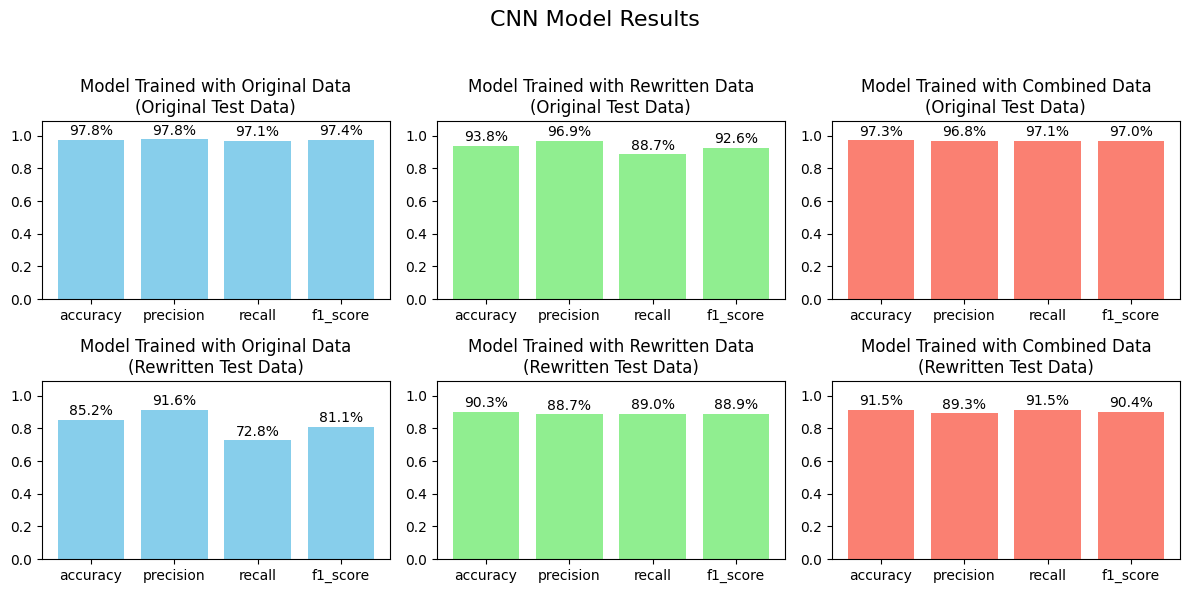

In [39]:
import matplotlib.pyplot as plt

def plot_results(
    perf_original_model_val_data, 
    perf_original_model_val_data_rewritten, 
    perf_combined_model_val_data, 
    perf_combined_model_val_data_rewritten, 
    perf_rewritten_model_val_data, 
    perf_rewritten_model_val_data_rewritten,
    ylim=1.09
):
    """
    Plot performance metrics of three models (trained with original, rewritten, or combined data)
    on two test sets (original vs rewritten). 
    """

    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle("CNN Model Results", fontsize=16)

    # Row 1 (Original Test Data), columns: Original-trained, Rewritten-trained, Combined-trained
    # 1) Model Trained with Original Data (Original Test Data)
    ax[0, 0].bar(
        perf_original_model_val_data.keys(),
        perf_original_model_val_data.values(),
        color='skyblue'
    )
    ax[0, 0].set_title("Model Trained with Original Data\n(Original Test Data)")
    ax[0, 0].set_ylim(0, ylim)
    for i, (metric, val) in enumerate(perf_original_model_val_data.items()):
        ax[0, 0].text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom')

    # 2) Model Trained with Rewritten Data (Original Test Data)
    ax[0, 1].bar(
        perf_rewritten_model_val_data.keys(),
        perf_rewritten_model_val_data.values(),
        color='lightgreen'
    )
    ax[0, 1].set_title("Model Trained with Rewritten Data\n(Original Test Data)")
    ax[0, 1].set_ylim(0, ylim)
    for i, (metric, val) in enumerate(perf_rewritten_model_val_data.items()):
        ax[0, 1].text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom')

    # 3) Model Trained with Combined Data (Original Test Data)
    ax[0, 2].bar(
        perf_combined_model_val_data.keys(),
        perf_combined_model_val_data.values(),
        color='salmon'
    )
    ax[0, 2].set_title("Model Trained with Combined Data\n(Original Test Data)")
    ax[0, 2].set_ylim(0, ylim)
    for i, (metric, val) in enumerate(perf_combined_model_val_data.items()):
        ax[0, 2].text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom')

    # Row 2 (Rewritten Test Data), columns: Original-trained, Rewritten-trained, Combined-trained
    # 1) Model Trained with Original Data (Rewritten Test Data)
    ax[1, 0].bar(
        perf_original_model_val_data_rewritten.keys(),
        perf_original_model_val_data_rewritten.values(),
        color='skyblue'
    )
    ax[1, 0].set_title("Model Trained with Original Data\n(Rewritten Test Data)")
    ax[1, 0].set_ylim(0, ylim)
    for i, (metric, val) in enumerate(perf_original_model_val_data_rewritten.items()):
        ax[1, 0].text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom')

    # 2) Model Trained with Rewritten Data (Rewritten Test Data)
    ax[1, 1].bar(
        perf_rewritten_model_val_data_rewritten.keys(),
        perf_rewritten_model_val_data_rewritten.values(),
        color='lightgreen'
    )
    ax[1, 1].set_title("Model Trained with Rewritten Data\n(Rewritten Test Data)")
    ax[1, 1].set_ylim(0, ylim)
    for i, (metric, val) in enumerate(perf_rewritten_model_val_data_rewritten.items()):
        ax[1, 1].text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom')

    # 3) Model Trained with Combined Data (Rewritten Test Data)
    ax[1, 2].bar(
        perf_combined_model_val_data_rewritten.keys(),
        perf_combined_model_val_data_rewritten.values(),
        color='salmon'
    )
    ax[1, 2].set_title("Model Trained with Combined Data\n(Rewritten Test Data)")
    ax[1, 2].set_ylim(0, ylim)
    for i, (metric, val) in enumerate(perf_combined_model_val_data_rewritten.items()):
        ax[1, 2].text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage:
plot_results(
    perf_original_model_val_data, 
    perf_original_model_val_data_rewritten, 
    perf_combined_model_val_data, 
    perf_combined_model_val_data_rewritten, 
    perf_rewritten_model_val_data, 
    perf_rewritten_model_val_data_rewritten
)